In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from astropy.table import Table
from matplotlib.markers import MarkerStyle

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table 

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2023):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21","t22"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021'",'2022'"]
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

## Reading the regression table

From latex to pandas

In [53]:
tab = Table.read('./tables/sqtreg_figure6_mothers_age3040_10_occ_women_kids.tex')
tab = tab.to_pandas(index='col0')

tab_m = Table.read('./tables/sqtreg_figure6_mothers_age3040_10_occ_men_kids.tex')
tab_m = tab_m.to_pandas(index='col0')
tab

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
col0,,,
Tenure Partner,$0.080^{***}$,$0.165^{***}$,$0.183^{***}$
NaN,(0.0020),(0.0023),(0.0027)
$t$,$0.049^{***}$,$0.062^{***}$,$0.019^{***}$
NaN,(0.0026),(0.0043),(0.0069)
$t^2$,$-0.001^{***}$,$-0.001^{***}$,$0.000$
NaN,(0.0000),(0.0001),(0.0001)
$t$ x kids,$0.041^{***}$,$-0.035^{***}$,$-0.066^{***}$
NaN,(0.0049),(0.0078),(0.0093)
$t^2$ x kids,$-0.000^{***}$,$0.001^{***}$,$0.001^{***}$


In [36]:
IoI = []
std_idx = []
for i,idx in enumerate(tab.index):
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='kids':
            IoI.append(idx)
            std_idx.append(i+1)
tab_dummies_f=tab.loc[IoI,:].copy()
tab_dummies_f_std=tab.iloc[std_idx,:].copy()
tab_dummies_f_std.index=[2020,2021,2022]
tab_dummies_f.index=[2020,2021,2022]

In [54]:
IoI = []
std_idx = []
for i,idx in enumerate(tab_m.index):
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='kids':
            IoI.append(idx)
            std_idx.append(i+1)
tab_dummies_m=tab_m.loc[IoI,:].copy()
tab_dummies_m_std=tab_m.iloc[std_idx,:].copy()
tab_dummies_m_std.index=[2020,2021,2022]
tab_dummies_m.index=[2020,2021,2022]

In [37]:
tab_dummies_f

,"Parents, 25th pctl","Parents, 50th pctl","Parents, 75th pctl"
2020,$-0.196^*$,$-0.275$,$0.337$
2021,$-0.509^{***}$,$-1.679^{***}$,$-0.064$
2022,$-0.525^{***}$,$-2.421^{***}$,$0.005$


In [55]:
coeffs_period_women, upper_women, lower_women = {}, {}, {}
coeffs_period_men, upper_men, lower_men = {}, {}, {}
for q in [25,50,75]:
    coef_i = tab_dummies_f.T.loc["Parents, {}th pctl".format(q),:]
    std_i = tab_dummies_f_std.T.loc["Parents, {}th pctl".format(q),:]
    std_i = [float(std.replace("(","").replace(")","")) for std in std_i ]
    coef_i = [float(coef.replace("*","").replace("$","").replace("^","").replace("{","").replace("}","")) for coef in coef_i ]
    upper_women[q] = np.array(coef_i) + 1.96*np.array(std_i)
    lower_women[q] = np.array(coef_i) - 1.96*np.array(std_i)
    coeffs_period_women[q] = np.array(coef_i)
    
    coef_i = tab_dummies_m.T.loc["Parents, {}th pctl".format(q),:]
    std_i = tab_dummies_m_std.T.loc["Parents, {}th pctl".format(q),:]
    std_i = [float(std.replace("(","").replace(")","")) for std in std_i ]
    coef_i = [float(coef.replace("*","").replace("$","").replace("^","").replace("{","").replace("}","")) for coef in coef_i ]
    upper_men[q] = np.array(coef_i) + 1.96*np.array(std_i)
    lower_men[q] = np.array(coef_i) - 1.96*np.array(std_i)
    coeffs_period_men[q] = np.array(coef_i)

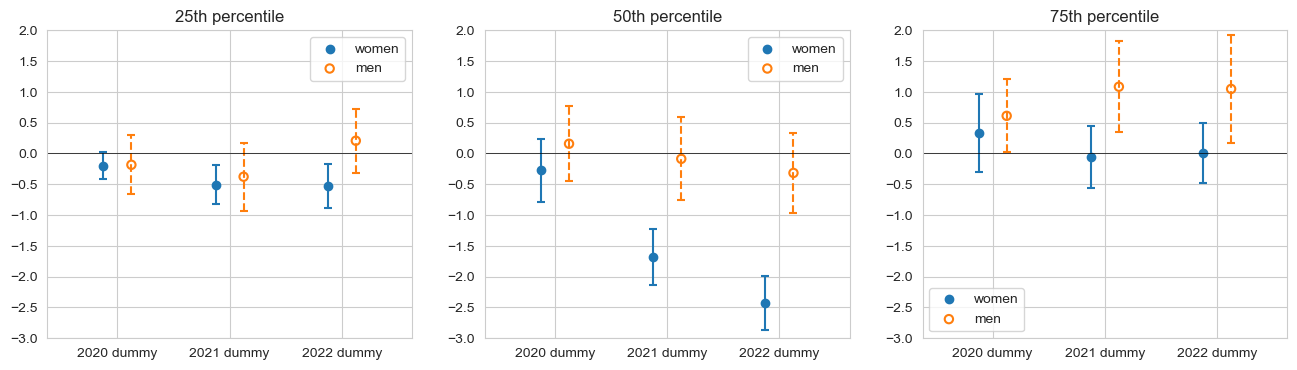

In [60]:
coeff_range = np.arange(len(coeffs_period_women.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))
mm = MarkerStyle(marker='o',fillstyle='none')


sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate([25,50,75]):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_women[q],marker='o',color=colors[0],label='women')
    plt.scatter(np.arange(0,3),upper_women[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_women[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_men[q],marker=mm,color=colors[1],
                label='men')
    plt.scatter(np.arange(0.25,3.25,1),upper_men[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_men[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_women[q][i],upper_women[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_men[q][i],upper_men[q][i]),c=colors[1],ls='--')
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3.,2)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.yticks(np.arange(-3,2.5,0.5))
    plt.xticks([0.125,1.125,2.125],['2020 dummy','2021 dummy','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/sqtreg_figure6_mothers_age3040_10_occ_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Age in bins

In [62]:
tab = Table.read('./tables/sqtreg_figure6_mothers_age3040_10_2016_ageint_women_kids.tex')
tab = tab.to_pandas(index='col0')

tab_m = Table.read('./tables/sqtreg_figure6_mothers_age3040_10_2016_ageint_men_kids.tex')
tab_m = tab_m.to_pandas(index='col0')
tab

IoI = []
std_idx = []
for i,idx in enumerate(tab.index):
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='kids':
            IoI.append(idx)
            std_idx.append(i+1)
tab_dummies_f=tab.loc[IoI,:].copy()
tab_dummies_f_std=tab.iloc[std_idx,:].copy()
tab_dummies_f_std.index=[2020,2021,2022]
tab_dummies_f.index=[2020,2021,2022]

IoI = []
std_idx = []
for i,idx in enumerate(tab_m.index):
    if str(idx)[:10]=="$\delta_{2":
        if idx.split(' x ')[-1]=='kids':
            IoI.append(idx)
            std_idx.append(i+1)
tab_dummies_m=tab_m.loc[IoI,:].copy()
tab_dummies_m_std=tab_m.iloc[std_idx,:].copy()
tab_dummies_m_std.index=[2020,2021,2022]
tab_dummies_m.index=[2020,2021,2022]

coeffs_period_women, upper_women, lower_women = {}, {}, {}
coeffs_period_men, upper_men, lower_men = {}, {}, {}
for q in [25,50,75]:
    coef_i = tab_dummies_f.T.loc["Parents, {}th pctl".format(q),:]
    std_i = tab_dummies_f_std.T.loc["Parents, {}th pctl".format(q),:]
    std_i = [float(std.replace("(","").replace(")","")) for std in std_i ]
    coef_i = [float(coef.replace("*","").replace("$","").replace("^","").replace("{","").replace("}","")) for coef in coef_i ]
    upper_women[q] = np.array(coef_i) + 1.96*np.array(std_i)
    lower_women[q] = np.array(coef_i) - 1.96*np.array(std_i)
    coeffs_period_women[q] = np.array(coef_i)
    
    coef_i = tab_dummies_m.T.loc["Parents, {}th pctl".format(q),:]
    std_i = tab_dummies_m_std.T.loc["Parents, {}th pctl".format(q),:]
    std_i = [float(std.replace("(","").replace(")","")) for std in std_i ]
    coef_i = [float(coef.replace("*","").replace("$","").replace("^","").replace("{","").replace("}","")) for coef in coef_i ]
    upper_men[q] = np.array(coef_i) + 1.96*np.array(std_i)
    lower_men[q] = np.array(coef_i) - 1.96*np.array(std_i)
    coeffs_period_men[q] = np.array(coef_i)

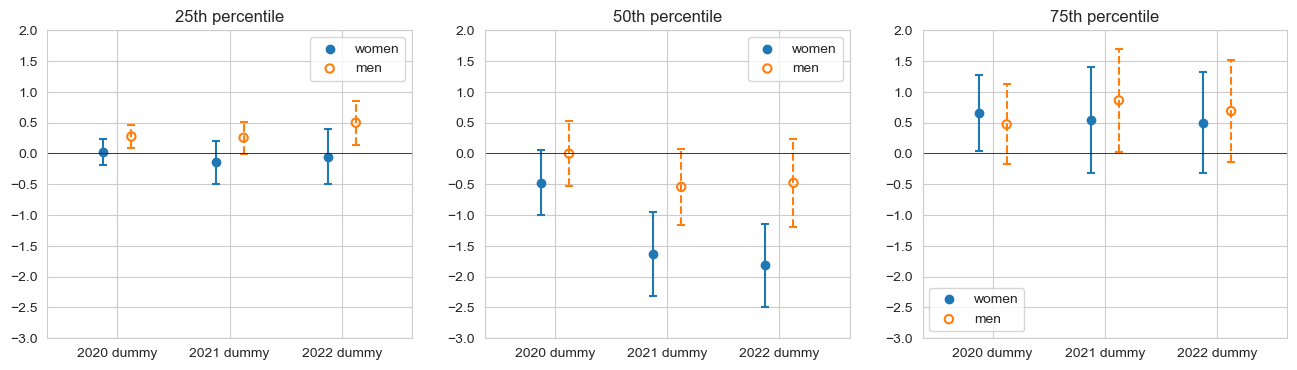

In [64]:
coeff_range = np.arange(len(coeffs_period_women.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))
mm = MarkerStyle(marker='o',fillstyle='none')


sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate([25,50,75]):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_women[q],marker='o',color=colors[0],label='women')
    plt.scatter(np.arange(0,3),upper_women[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_women[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_men[q],marker=mm,color=colors[1],
                label='men')
    plt.scatter(np.arange(0.25,3.25,1),upper_men[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_men[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_women[q][i],upper_women[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_men[q][i],upper_men[q][i]),c=colors[1],ls='--')
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3.,2)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.yticks(np.arange(-3,2.5,0.5))
    plt.xticks([0.125,1.125,2.125],['2020 dummy','2021 dummy','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/sqtreg_figure6_mothers_age3040_10_2016_ageint_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()